- the goal of the analysis is to get a feeling of the liquidity of different options over time:
    - which options are traded compared to the current index level?
    - what are bid-ask spreads?
    - how many open contracts exist?

In [1]:
@time include("../startup_script.jl")

elapsed time: 0.460727552 seconds (51752124 bytes allocated, 5.95% gc time)
elapsed time: 47.357482275 seconds (5419744204 bytes allocated, 65.58% gc time)
elapsed time: 0.639806439 seconds (112671592 bytes allocated, 48.26% gc time)
elapsed time: 62.053046857 seconds (5419744204 bytes allocated, 72.52% gc time)
elapsed time: 130.814977989 seconds (14789282300 bytes allocated, 60.38% gc time)


,Date,ID,Bid,Ask,Volume,Open_Interest
1,2006-07-03,c_20061215_1800,NA,NA,1,104
2,2006-07-03,p_20061215_1800,NA,NA,0,5515
3,2006-07-03,c_20061215_2000,NA,NA,0,2152
4,2006-07-03,p_20061215_2000,NA,NA,0,20941
5,2006-07-03,c_20061215_2200,NA,NA,0,2
6,2006-07-03,p_20061215_2200,NA,NA,0,4626


### Volume data

volume data has the following characteristics:
- only very few missing values (~11)
- most data values are zero (~70%)
- the shape of the remaining values resembles an exponential distribution: the larger the volume, the less associated observations

for graphics volume data should be scaled:
- zero volumes will be left untransformed and treated separately in the graphics
- all other values are taken for themselves and rescaled via probability integral transformation

- loading Econometrics package for `ranks` function

In [2]:
using Econometrics
loadPlotting()

wstHist (generic function with 4 methods)

- build the required initial data table

In [3]:
liquData = join(addObs, opts, on = :ID) |>
x -> join(x, daxVals, on = :Date)

nObs = size(liquData, 1)

head(liquData)

,Date,ID,Bid,Ask,Volume,Open_Interest,Expiry,Strike,IsCall,DAX
1,2006-07-03,c_20060721_4500,NA,NA,0,127,2006-07-21,4500,true,5712.69
2,2006-07-03,c_20060721_4600,NA,NA,0,235,2006-07-21,4600,true,5712.69
3,2006-07-03,c_20060721_4700,NA,NA,0,212,2006-07-21,4700,true,5712.69
4,2006-07-03,c_20060721_4800,NA,NA,0,2749,2006-07-21,4800,true,5712.69
5,2006-07-03,c_20060721_4850,NA,NA,0,122,2006-07-21,4850,true,5712.69
6,2006-07-03,c_20060721_4900,NA,NA,0,413,2006-07-21,4900,true,5712.69


#### Show original volume data

- show missing values

In [4]:
naObs = isna(liquData[:Volume])
liquData[naObs, :]

,Date,ID,Bid,Ask,Volume,Open_Interest,Expiry,Strike,IsCall,DAX
1,2007-11-27,c_20080919_7800,NA,NA,NA,1018,2008-09-19,7800,true,7531.35
2,2007-11-27,c_20080919_8800,NA,NA,NA,6348,2008-09-19,8800,true,7531.35
3,2007-11-27,p_20080919_8800,NA,NA,NA,49,2008-09-19,8800,false,7531.35
4,2008-05-22,c_20080919_7000,NA,NA,NA,23325,2008-09-19,7000,true,7070.33
5,2008-05-22,c_20080919_7800,NA,NA,NA,10099,2008-09-19,7800,true,7070.33
6,2008-05-22,c_20080919_8800,NA,NA,NA,7943,2008-09-19,8800,true,7070.33
7,2008-05-22,p_20080919_8800,NA,NA,NA,247,2008-09-19,8800,false,7070.33
8,2008-05-23,c_20080919_7000,NA,NA,NA,23833,2008-09-19,7000,true,6944.05
9,2008-05-23,c_20080919_7800,NA,NA,NA,11568,2008-09-19,7800,true,6944.05
10,2008-05-23,c_20080919_8800,NA,NA,NA,7940,2008-09-19,8800,true,6944.05


- count zeros

In [5]:
sum(convert(Array, liquData[:Volume] .== 0, false)) / nObs

0.7067263369395234

- show distribution of non-zero entries

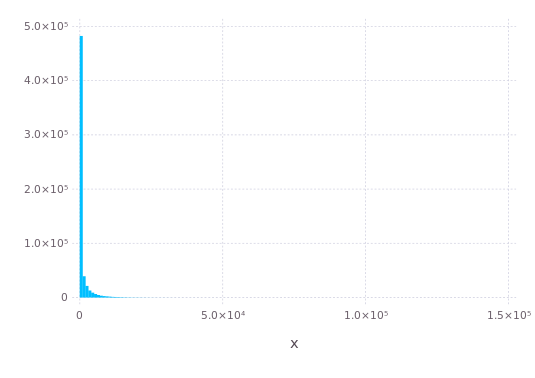

In [6]:
nonZeroInds = convert(Array, liquData[:Volume] .!= 0, false)
Gadfly.plot(x=liquData[:Volume][nonZeroInds], Gadfly.Geom.histogram)

#### Rescale non-zero values

- find non zero entries

In [7]:
nonZeroVals = liquData[:Volume][nonZeroInds]
scaledVolVals = ranks(nonZeroVals)

# preallocation
scaledVols = zeros(nObs)
scaledVols[nonZeroInds] = scaledVolVals

# append to data
liquData[:VolRanks] = scaledVols

head(liquData)

,Date,ID,Bid,Ask,Volume,Open_Interest,Expiry,Strike,IsCall,DAX,VolRanks
1,2006-07-03,c_20060721_4500,NA,NA,0,127,2006-07-21,4500,true,5712.69,0.0
2,2006-07-03,c_20060721_4600,NA,NA,0,235,2006-07-21,4600,true,5712.69,0.0
3,2006-07-03,c_20060721_4700,NA,NA,0,212,2006-07-21,4700,true,5712.69,0.0
4,2006-07-03,c_20060721_4800,NA,NA,0,2749,2006-07-21,4800,true,5712.69,0.0
5,2006-07-03,c_20060721_4850,NA,NA,0,122,2006-07-21,4850,true,5712.69,0.0
6,2006-07-03,c_20060721_4900,NA,NA,0,413,2006-07-21,4900,true,5712.69,0.0


### Open interest

open interest data has the following characterstics:

- no missing values

In [8]:
sum(isna(liquData[:Open_Interest])) / nObs

0.0

- all values are positive

In [9]:
sum(liquData[:Open_Interest] .== 0) / nObs

0.0

- distribution of open interest values

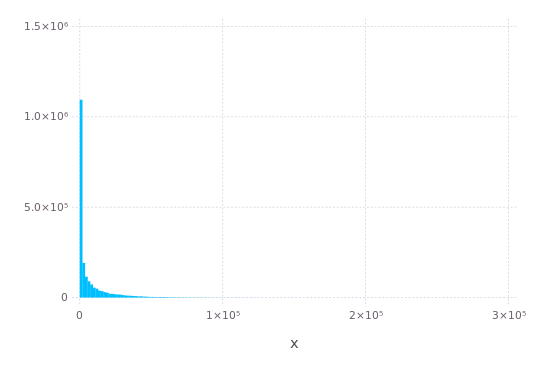

In [10]:
Gadfly.plot(x=liquData[:Open_Interest], Gadfly.Geom.histogram)

- showing open interest over time

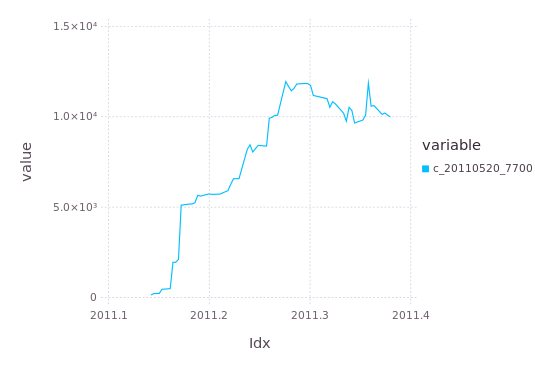

In [11]:
# pick random option
nOpts = size(opts, 1)
rndOpt = rand(1:nOpts)

# get associated observations
optName = opts[rndOpt, :ID]
singleOptData = liquData[liquData[:ID] .== optName, :]

singleOptOI = DataFrame(option = singleOptData[:Open_Interest])
names!(singleOptOI, [symbol(optName)])

# plot open interest
singleOptDataTm = Timematr(singleOptOI, convert(Array, singleOptData[:Date]))
gdfPlot(singleOptDataTm)

- calculate open interest changes for each observation

In [12]:
# preallocation
liquData[:DeltaOI] = zeros(nObs)

@time begin

    for opt in opts[:ID]
        optionInds = liquData[:ID] .== opt
    
        # get data
        singleOptData = convert(Array, liquData[optionInds, :Open_Interest])
    
        # get differences
        deltaOI = [singleOptData[1], diff(singleOptData)]
        liquData[optionInds, :DeltaOI] = deltaOI
    end
end

elapsed time: 1195.381671099 seconds (29553487832 bytes allocated, 17.16% gc time)


In [13]:
head(liquData)

,Date,ID,Bid,Ask,Volume,Open_Interest,Expiry,Strike,IsCall,DAX,VolRanks,DeltaOI
1,2006-07-03,c_20060721_4500,NA,NA,0,127,2006-07-21,4500,true,5712.69,0.0,127.0
2,2006-07-03,c_20060721_4600,NA,NA,0,235,2006-07-21,4600,true,5712.69,0.0,235.0
3,2006-07-03,c_20060721_4700,NA,NA,0,212,2006-07-21,4700,true,5712.69,0.0,212.0
4,2006-07-03,c_20060721_4800,NA,NA,0,2749,2006-07-21,4800,true,5712.69,0.0,2749.0
5,2006-07-03,c_20060721_4850,NA,NA,0,122,2006-07-21,4850,true,5712.69,0.0,122.0
6,2006-07-03,c_20060721_4900,NA,NA,0,413,2006-07-21,4900,true,5712.69,0.0,413.0


- test delta open interest

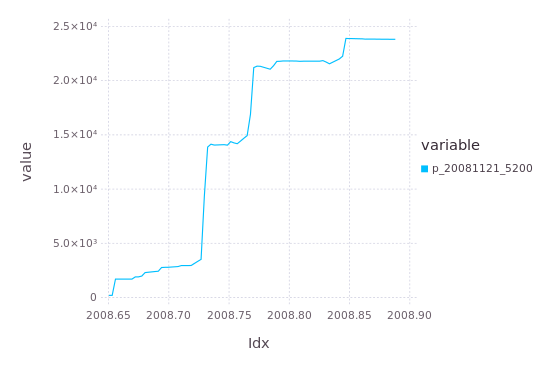

In [14]:
# pick random option
rndOpt = rand(1:nOpts)

# get associated observations
optName = opts[rndOpt, :ID]
singleOptData = liquData[liquData[:ID] .== optName, :]

singleOptOI = DataFrame(option = singleOptData[:Open_Interest])
names!(singleOptOI, [symbol(optName)])

# plot open interest
singleOptDataTm = Timematr(singleOptOI, convert(Array, singleOptData[:Date]))
gdfPlot(singleOptDataTm)

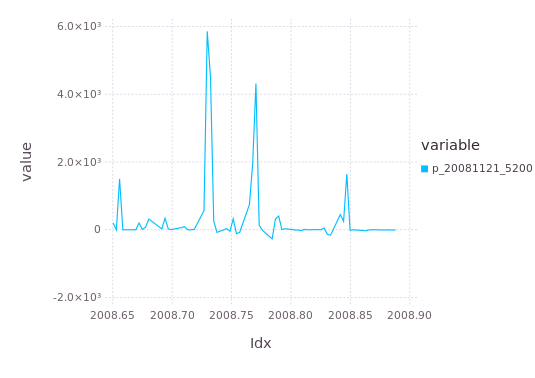

In [15]:
# get associated observations
singleOptOI = DataFrame(option = singleOptData[:DeltaOI])
names!(singleOptOI, [symbol(optName)])

# plot open interest
singleOptDataTm = Timematr(singleOptOI, convert(Array, singleOptData[:Date]))
gdfPlot(singleOptDataTm)

- scaling open interest data

In [16]:
scaledOI = ranks(liquData[:Open_Interest])

# append to data
liquData[:OiRanks] = scaledOI

head(liquData)

,Date,ID,Bid,Ask,Volume,Open_Interest,Expiry,Strike,IsCall,DAX,VolRanks,DeltaOI,OiRanks
1,2006-07-03,c_20060721_4500,NA,NA,0,127,2006-07-21,4500,true,5712.69,0.0,127.0,0.2099924449294613
2,2006-07-03,c_20060721_4600,NA,NA,0,235,2006-07-21,4600,true,5712.69,0.0,235.0,0.2776527926602243
3,2006-07-03,c_20060721_4700,NA,NA,0,212,2006-07-21,4700,true,5712.69,0.0,212.0,0.266840647267089
4,2006-07-03,c_20060721_4800,NA,NA,0,2749,2006-07-21,4800,true,5712.69,0.0,2749.0,0.5951864818554858
5,2006-07-03,c_20060721_4850,NA,NA,0,122,2006-07-21,4850,true,5712.69,0.0,122.0,0.2063181129112699
6,2006-07-03,c_20060721_4900,NA,NA,0,413,2006-07-21,4900,true,5712.69,0.0,413.0,0.3434964668934834


### Save data to disk

- split into call and put data

In [17]:
callLiquData = liquData[liquData[:IsCall], :];
putLiquData = liquData[!(liquData[:IsCall]), :];

- save data to disk

In [18]:
writetable("../data/chart_data/callLiquidityData.csv", callLiquData)
writetable("../data/chart_data/putLiquidityData.csv", putLiquData)

### Bid-ask spreads

- count missing values for bid and ask quotes

In [19]:
sum(isna(liquData[:Bid]))/size(liquData, 1)

0.7890529442815741

In [20]:
sum(isna(liquData[:Ask]))/size(liquData, 1)

0.7773144328089717

### Session info

In [21]:
versioninfo()

Julia Version 0.3.5
Commit a05f87b* (2015-01-08 22:33 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i3-3240 CPU @ 3.40GHz
  WORD_SIZE: 64
  BLAS: libblas.so.3
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


In [22]:
Pkg.status()

20 required packages:
 - DataArrays                    0.2.16
 - DataFrames                    0.6.7
 - Dates                         0.3.2
 - Debug                         0.1.3
 - Distributions                 0.7.4
 - Docile                        0.5.12
 - GLM                           0.4.6
 - Gadfly                        0.3.13
 - IJulia                        0.2.5
 - JuMP                          0.9.2
 - Lexicon                       0.1.13
 - MAT                           0.2.12
 - NLopt                         0.2.1
 - Plotly                        0.0.3+             master
 - Quandl                        0.4.2
 - RDatasets                     0.1.2
 - Requires                      0.1.2+             master
 - Taro                          0.1.4
 - TimeSeries                    0.5.10
 - Winston                       0.11.11
58 additional packages:
 - ArrayViews                    0.6.2
 - AssetMgmt                     0.0.0-             master (unregistered)
 - BinDeps   